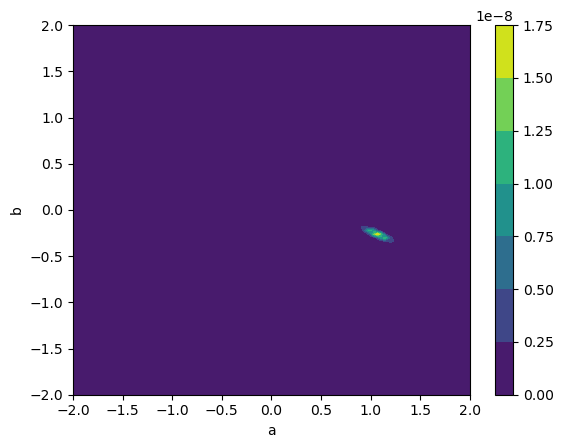

2D 2.56848e-10, 3D 6.80803e-11, Bayes factor 3.77


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#prior_ranges = [[-0.5, 0.5], [0.5, 1.5], [-0.5, 0.5]]
prior_ranges = [[-2., 2.], [-2., 2.], [-2., 2.]]

def getDataPoints(name):
    xi = []
    yi = []
    dyi = []
    fdata = open(name,'r')
    for line in fdata.readlines():
        xi.append(float(line.split()[0]))
        yi.append(float(line.split()[1]))
        dyi.append(float(line.split()[2]))
    # convert to numpy arrays
    xi1 = np.array(xi)
    yi1 = np.array(yi)
    dyi1 = np.array(dyi)
    return xi1, yi1, dyi1
       
def polymodel(params, x):
    f = 0. # keep track of function value
    for i in range(len(params)):
        f += params[i] * (x**i) # f = a + bx + cx**2 + ...
    return f
        
def logLike(xi,yi,dyi,params):
    lnL = 0.
    for i in range(len(xi)):
        model = polymodel(params, xi[i])
        # update lnL, include normalization
        lnL -= (((yi[i]-model)**2/(2*dyi[i]**2)) - 0.5*np.log(2*np.pi*dyi[i]))
    return lnL

def flatprior(params):
    # make the prior zero outside of the range
    prior = 1.
    for i in range(len(params)):
        if params[i] < prior_ranges[i][0] or params[i] > prior_ranges[i][1]:
            return 0.
        prior *= (1./(prior_ranges[i][1]-prior_ranges[i][0]))
    return prior

def pdf2d(a,b,xi,yi,dyi):
    params = [a,b]
    lnL = logLike(xi,yi,dyi,params)
    lnprior = np.log(flatprior(params))
    return np.exp(lnL+lnprior)

def pdf3d(a,b,c,xi,yi,dyi):
    params = [a,b,c]
    lnL = logLike(xi,yi,dyi,params)
    lnprior = np.log(flatprior(params))
    return np.exp(lnL+lnprior)

xi, yi, dyi = getDataPoints('model_selection.txt')

# for plotting the 2d result
alin = np.linspace(-2., 2., 100)
blin = np.linspace(-2., 2., 100)

limits2d = [[-2., 2.], [-2., 2.]]
prob2d, error = scipy.integrate.nquad(pdf2d, limits2d, args=(xi, yi, dyi))

# Not sure why I can't call pdf2d on linspaces and get a 2d array but whatever
pdf2dvals = np.arange(len(alin)*len(blin),dtype=float).reshape(len(alin),len(blin))
for ia in range(len(alin)):
    for ib in range(len(blin)):
        pdf2dvals[ia][ib] = pdf2d(alin[ia], blin[ib], xi, yi, dyi)
        
plt.contourf(alin, blin, pdf2dvals)
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar()
plt.show()

limits3d = [[-2., 2.], [-2., 2.], [-2., 2.]]
prob3d, error = scipy.integrate.nquad(pdf3d, limits3d, args=(xi, yi, dyi))

print("2D %g, 3D %g, Bayes factor %2.2f" % (prob2d, prob3d, prob2d/prob3d))


The Bayes factor favors model $M_{1}$ mainly because it has less wasted phase space with one fewer parameter. The phase space penalty for $M_{2}$ is substantial. Reducing the allowed prior ranges decerases the Bayes factor, but not enough to actually prefer the quadratic model.

In [7]:
def chi2(params, xi, yi, dyi):
    chi2 = 0.
    for i in range(len(xi)):
        model = polymodel(params, xi[i])
        chi2 += (yi[i]-model)**2/dyi[i]**2
    return chi2

result2d = scipy.optimize.minimize(chi2, [0., 0.], args=(xi,yi,dyi), method='BFGS')
minchi22d = chi2(result2d.x, xi, yi, dyi)

result3d = scipy.optimize.minimize(chi2, [0., 0., 0.], args=(xi,yi,dyi), method='BFGS')
minchi23d = chi2(result3d.x, xi, yi, dyi)

print("2 parameter fit: chi2 %2.2f at a = %2.2f, b = %2.2f" % (minchi22d, result2d.x[0], result2d.x[1]))
print("3 parameter fit: chi2 %2.2f at a = %2.2f, b = %2.2f, c = %2.2f" % (minchi23d, result3d.x[0], result3d.x[1], result3d.x[2]))

N = len(xi)

pval2d = scipy.stats.chi2.sf(minchi22d, N-2)
pval3d = scipy.stats.chi2.sf(minchi23d, N-3)
pvaldiff = scipy.stats.chi2.sf(minchi22d-minchi23d, 1)

print("2 parameter fit: p-val = %3.3f" % pval2d)
print("3 parameter fit: p-val = %3.3f" % pval3d)
print("deltaChi2: p-val = %3.3f" % pvaldiff)

2 parameter fit: chi2 20.89 at a = -0.26, b = 1.07
3 parameter fit: chi2 19.88 at a = -0.22, b = 0.79, c = 0.32
2 parameter fit: p-val = 0.285
3 parameter fit: p-val = 0.280
deltaChi2: p-val = 0.317


The p-values for the 2-parameter and 3-parameter fit are both reasonable. When we consider the difference in the $\chi^{2}$ for the two nested models compared to the distribution for 1 degree of freedom, we get a high p-value of 0.317. This tells us that both models fit the data reasonably well. We know that there is no penalty for added model complexity in this analysis, so the fact that both models give good fits means that we should prefer the simpler linear model.